In [1]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np

In [2]:
run_name = "MNIST Persistent Diagrams"

In [3]:
get_model_directory = lambda series, cut: "models/{}_series/{}_cut/".format(series, cut)
get_model_name = lambda number:  "m_{}.h5".format(number)

model_name = lambda series_num, cut_val, model_num: get_model_directory(series_num, cut_val) + get_model_name(model_num)

- На модельной задаче извлечь градиенты косинусного расстояния и нарисовать меняющиеся персистентные диаграммы
- Сделать то же самое, но на старых данных

In [4]:
input_size = 784
params = [64,64,10]

In [5]:
import datetime 
def log_preamble(log_file_name):
    global tries, epochs, series, file_name
    time_stamp = datetime.datetime.now()

    with open(log_file_name, "a") as log_file:
        log_file.write(f"\n{run_name}")
        log_file.write(f"\n\nExecuted on time is {datetime.datetime.now()}\n")
        log_file.write(f"Tries: {tries}, epochs: {epochs}, series = {series}\n")
        log_file.write(f"Network configuration is {params}\n")
    return time_stamp

# def log(log_file_name, time_stamp):

def log_final(log_file_name, time_stamp):
    time_stamp_new = datetime.datetime.now()
    with open(log_file_name, "a") as log_file:
        log_file.write(f"Finished successfully at {time_stamp_new}\n")
        log_file.write(f"Total time = {(time_stamp_new - time_stamp).total_seconds()}\n")

In [14]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(params[0], activation="relu")(inputs)
x2 = layers.Dense(params[1], activation="relu")(x1)
outputs = layers.Dense(params[2], name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the training dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

# Reserve 10,000 samples for validation.
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [16]:
epochs = 120

grads_snapshot = []

series = 1004242
count = 0
rate = 200

losses = []
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        if step % rate == 0:
            count += 1
            grads_snapshot.append(grads)
            model.save(model_name(series, 0, count))
            print(f"Saved model #{count}")
            
        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            losses.append(float(loss_value))
            print("Seen so far: %s samples" % ((step + 1) * batch_size))



Start of epoch 0
Saved model #1
Training loss (for one batch) at step 0: 68.9263
Seen so far: 64 samples
Saved model #2
Training loss (for one batch) at step 200: 1.4623
Seen so far: 12864 samples
Saved model #3
Training loss (for one batch) at step 400: 0.7457
Seen so far: 25664 samples
Saved model #4
Training loss (for one batch) at step 600: 0.7835
Seen so far: 38464 samples

Start of epoch 1
Saved model #5
Training loss (for one batch) at step 0: 0.7012
Seen so far: 64 samples
Saved model #6
Training loss (for one batch) at step 200: 0.8163
Seen so far: 12864 samples
Saved model #7
Training loss (for one batch) at step 400: 0.2889
Seen so far: 25664 samples
Saved model #8
Training loss (for one batch) at step 600: 0.5311
Seen so far: 38464 samples

Start of epoch 2
Saved model #9
Training loss (for one batch) at step 0: 0.7099
Seen so far: 64 samples
Saved model #10
Training loss (for one batch) at step 200: 0.5045
Seen so far: 12864 samples
Saved model #11
Training loss (for one 

In [19]:
count

480

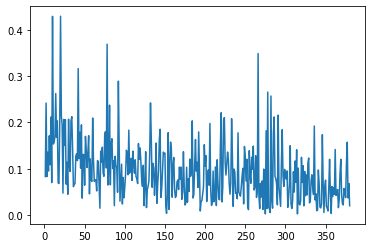

In [23]:
import matplotlib.pyplot as plt

y = losses[100:]
plt.plot(list(range(1, len(y)+1)), y)